In [1]:
pip install pytorch-lightning pytorch-forecasting pandas matplotlib seaborn scikit-learn


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### **Dataset Exploration**

In [2]:
import pandas as pd

# Load the merged time-series dataset
df_merged = pd.read_csv('merged_patient_time_series.csv', parse_dates=['event_timestamp'])

print(f"Loaded dataset shape: {df_merged.shape}")
print(df_merged.head())


Loaded dataset shape: (165716, 39)
   empi_nbr_anon     event_timestamp  DAYS_TO_HEAL  LAST_WOUND_AGE_DAYS  \
0       10030580 2023-04-05 06:00:00           NaN                  NaN   
1       10030580 2023-04-05 06:00:00           NaN                  NaN   
2       10030580 2023-04-05 06:00:00           NaN                  NaN   
3       10030580 2023-04-05 06:00:00           NaN                  NaN   
4       10030580 2023-04-05 06:00:00           NaN                  NaN   

   PAT_AGE_YEARS_FIRST_ASSESS  STAGE_INITIAL_C  STAGE_CURRENT_C  \
0                         NaN              NaN              NaN   
1                         NaN              NaN              NaN   
2                         NaN              NaN              NaN   
3                         NaN              NaN              NaN   
4                         NaN              NaN              NaN   

   PCT_HEALED_LAST_ENC  PCT_AREA_HEALED  PCT_VOLUME_HEALED  ...  \
0                  NaN              NaN     

In [3]:
# Convert event_timestamp to relative integer time index
df_merged = df_merged.sort_values(["empi_nbr_anon", "event_timestamp"])

# Create time_idx: counts timestamps per patient
df_merged["time_idx"] = df_merged.groupby("empi_nbr_anon").cumcount()

# Check basic
print(df_merged[['empi_nbr_anon', 'event_timestamp', 'time_idx']].head(10))


   empi_nbr_anon     event_timestamp  time_idx
0       10030580 2023-04-05 06:00:00         0
1       10030580 2023-04-05 06:00:00         1
2       10030580 2023-04-05 06:00:00         2
3       10030580 2023-04-05 06:00:00         3
4       10030580 2023-04-05 06:00:00         4
5       10030580 2023-04-05 06:00:00         5
6       10030580 2023-04-05 06:00:00         6
7       10030580 2023-04-05 06:00:00         7
8       10030580 2023-04-05 06:00:00         8
9       10030580 2023-04-05 06:23:00         9


In [4]:
#Drop FIRST_DATE_anon
if 'FIRST_DATE_anon' in df_merged.columns:
    df_merged = df_merged.drop(columns=['FIRST_DATE_anon'])
    print("Dropped 'FIRST_DATE_anon'.")


Dropped 'FIRST_DATE_anon'.


In [68]:
num_patients = df_merged["empi_nbr_anon"].nunique()
print(f"Number of unique patients: {num_patients}")


Number of unique patients: 2072


In [5]:
df_merged.isna().sum()

empi_nbr_anon                                0
event_timestamp                              0
DAYS_TO_HEAL                            145078
LAST_WOUND_AGE_DAYS                     145078
PAT_AGE_YEARS_FIRST_ASSESS              145078
STAGE_INITIAL_C                         155561
STAGE_CURRENT_C                         155561
PCT_HEALED_LAST_ENC                     150624
PCT_AREA_HEALED                         153594
PCT_VOLUME_HEALED                       155021
NUM_OUTPAT_HOV_VISITS                   145078
gender                                  145078
race                                    145078
ethnicity                               145078
is_deceased                             145078
Braden Scale Score                       61316
Closure                                  61316
Drainage Amount                          61316
Drainage Description                     61316
Dressing                                 61316
Dressing Changed                         61316
Friction and 

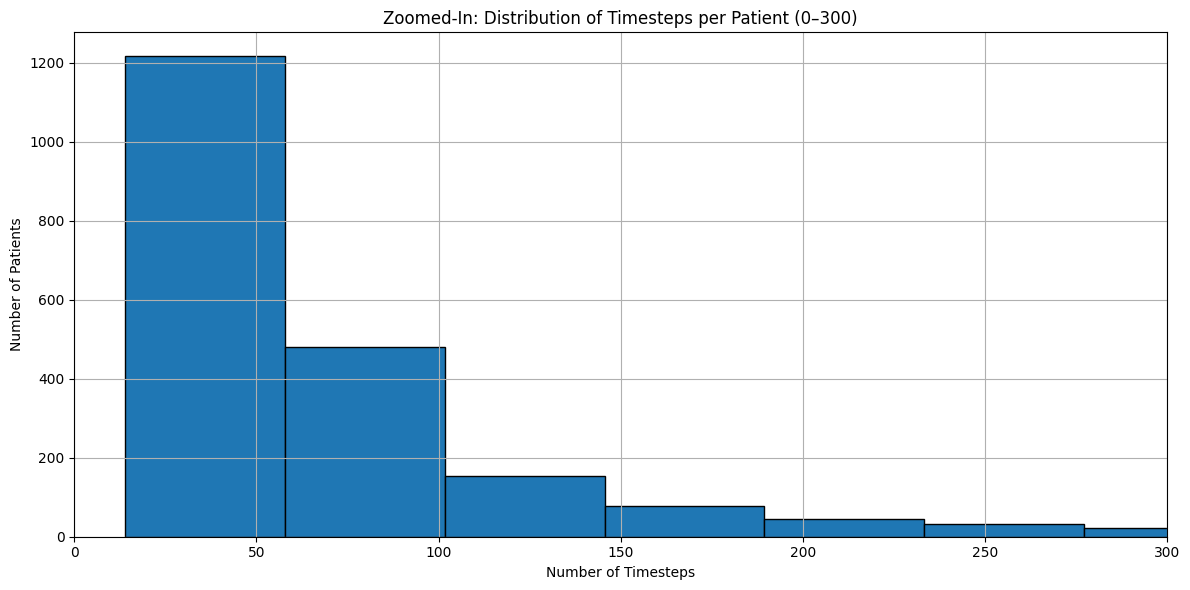

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Drop high-missingness columns
columns_to_drop = [
    "STAGE_INITIAL_C", "STAGE_CURRENT_C",
    "PCT_HEALED_LAST_ENC", "PCT_AREA_HEALED", "PCT_VOLUME_HEALED"
]
# Drop only those that are present in the DataFrame
existing_cols_to_drop = [col for col in columns_to_drop if col in df_merged.columns]
df_merged = df_merged.drop(columns=existing_cols_to_drop)

# Step 2: Sort by patient and timestamp
df_merged = df_merged.sort_values(["empi_nbr_anon", "event_timestamp"])

# Step 3: Compute timesteps per patient
timesteps_per_patient = df_merged.groupby("empi_nbr_anon")["event_timestamp"].count()
timesteps_per_patient.describe()

plt.figure(figsize=(12, 6))
plt.hist(timesteps_per_patient, bins=50, edgecolor='black')
plt.xlim(0, 300)  
plt.title("Zoomed-In: Distribution of Timesteps per Patient (0–300)")
plt.xlabel("Number of Timesteps")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.tight_layout()
plt.show()



### **Align the Timesteps across all the selected patients**

In [7]:
# Step 1: Count timesteps per patient
timesteps_per_patient = df_merged.groupby("empi_nbr_anon")["event_timestamp"].count()

# Step 2: Filter and count value frequencies for patients with <30 timesteps
timesteps_below_49 = timesteps_per_patient[timesteps_per_patient < 49]
value_counts = timesteps_below_49.value_counts().sort_index()

# Step 3: Print value count summary
print("Timestep count distribution for patients with <49 timesteps:")
print(value_counts)
print(f"\nTotal patients with <48 timesteps: {timesteps_below_49.shape[0]}")


Timestep count distribution for patients with <49 timesteps:
event_timestamp
14     1
15     4
16     1
17     4
18     1
19     3
20     3
21     1
22    10
23    19
24    35
25    40
26    55
27    49
28    52
29    52
30    57
31    47
32    57
33    45
34    50
35    30
36    43
37    45
38    29
39    40
40    32
41    37
42    30
43    31
44    29
45    23
46    31
47    22
48    27
Name: count, dtype: int64

Total patients with <48 timesteps: 1035


In [8]:
import pandas as pd

# Step 1: Count timesteps per patient
timesteps_per_patient = df_merged.groupby("empi_nbr_anon")["event_timestamp"].count()

# Step 2: Filter patients with at least 49 time steps
eligible_patients = timesteps_per_patient[timesteps_per_patient >= 49].index
df_filtered = df_merged[df_merged["empi_nbr_anon"].isin(eligible_patients)]

# Step 3: Define function to keep most complete 49 rows per patient
def trim_patient_group(group, max_timesteps=49):
    # Compute non-null count for each row
    group = group.copy()
    group["non_null_count"] = group.notnull().sum(axis=1)
    
    # Sort by non-null count (descending) to keep most complete rows
    trimmed_group = group.sort_values("non_null_count", ascending=False).head(max_timesteps)
    
    return trimmed_group.drop(columns=["non_null_count"])

# Step 4: Apply trimming function
df_trimmed = (
    df_filtered.groupby("empi_nbr_anon", group_keys=False)
    .apply(trim_patient_group)
    .reset_index(drop=True)
)

print(f"Final trimmed shape: {df_trimmed.shape}")


Final trimmed shape: (50813, 34)


/tmp/ipykernel_3635272/3112614667.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(trim_patient_group)


In [9]:
df_trimmed.isna().sum()

empi_nbr_anon                               0
event_timestamp                             0
DAYS_TO_HEAL                            45929
LAST_WOUND_AGE_DAYS                     45929
PAT_AGE_YEARS_FIRST_ASSESS              45929
NUM_OUTPAT_HOV_VISITS                   45929
gender                                  45929
race                                    45929
ethnicity                               45929
is_deceased                             45929
Braden Scale Score                       8822
Closure                                  8822
Drainage Amount                          8822
Drainage Description                     8822
Dressing                                 8822
Dressing Changed                         8822
Friction and Shear                       8822
In Bed Mobility                          8822
Location                                 8822
Margins                                  8822
Moisture                                 8822
Nutrition                         

All these missing values are due to misalignment of timesteps, which is very common in medical datasets - because in real life settings, the patient might not be evaluated on all the parameters at the same-time during the same day. 
Let's use forward fill and backward fill to impute the data in static columns- as they do not tend to change with time.

In [10]:
# Step 1: Drop unnecessary columns if they exist
columns_to_drop = ["LAST_WOUND_AGE_DAYS", "NUM_OUTPAT_HOV_VISITS"]
df_trimmed = df_trimmed.drop(columns=[col for col in columns_to_drop if col in df_trimmed.columns])

# Step 2: Define static columns to forward-fill (per patient)
static_cols = ["PAT_AGE_YEARS_FIRST_ASSESS", "gender", "race", "ethnicity", "is_deceased"]

# Step 3: Ensure sorting by patient and timestamp
df_trimmed = df_trimmed.sort_values(["empi_nbr_anon", "event_timestamp"]).reset_index(drop=True)

# Step 4: Forward-fill and backfill static columns within each patient group
for col in static_cols:
    if col in df_trimmed.columns:
        df_trimmed[col] = (
            df_trimmed.groupby("empi_nbr_anon")[col]
            .transform(lambda x: x.ffill().bfill())
        )


print("Columns dropped and static fields forward/backward filled.")


/tmp/ipykernel_3635272/2651097929.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .transform(lambda x: x.ffill().bfill())


Columns dropped and static fields forward/backward filled.


Values for some patients got removed due to trimming, hence matched them with patient_id and retrieved their information.

In [12]:
# List of static columns to fill
static_cols = ["PAT_AGE_YEARS_FIRST_ASSESS", "gender", "race", "ethnicity", "is_deceased"]

# Step 1: Build a static value lookup from df_merged (first non-null per patient)
static_lookup = df_merged.dropna(subset=static_cols).groupby("empi_nbr_anon")[static_cols].first()

# Step 2: Use map to assign back to df_trimmed where values are missing
for col in static_cols:
    df_trimmed[col] = df_trimmed[col].fillna(df_trimmed["empi_nbr_anon"].map(static_lookup[col]))


In [13]:
print(df_trimmed[static_cols].isna().sum())


PAT_AGE_YEARS_FIRST_ASSESS    0
gender                        0
race                          0
ethnicity                     0
is_deceased                   0
dtype: int64


In [14]:
df_trimmed.isna().sum()

empi_nbr_anon                               0
event_timestamp                             0
DAYS_TO_HEAL                            45929
PAT_AGE_YEARS_FIRST_ASSESS                  0
gender                                      0
race                                        0
ethnicity                                   0
is_deceased                                 0
Braden Scale Score                       8822
Closure                                  8822
Drainage Amount                          8822
Drainage Description                     8822
Dressing                                 8822
Dressing Changed                         8822
Friction and Shear                       8822
In Bed Mobility                          8822
Location                                 8822
Margins                                  8822
Moisture                                 8822
Nutrition                                8822
Out of Bed Activity                      8822
Peri-Wound Assessment             

Opted a similiar technique to extract patient related information from the original lab and comorbidity datasets

In [15]:
import pandas as pd
import numpy as np

#Load lab dataset
df_lab = pd.read_csv("complete_lab.csv")

# Step 0: Make sure timestamps are in datetime format
df_trimmed["event_timestamp"] = pd.to_datetime(df_trimmed["event_timestamp"])
df_lab["lab_result_time_anon"] = pd.to_datetime(df_lab["lab_result_time_anon"])

# Step 1: Clean and subset lab dataset
df_trimmed = df_trimmed.drop(columns=["DX_NAME"], errors="ignore")  # Optional column drop
df_lab = df_lab.dropna(subset=["component", "lab_result"])
df_lab = df_lab[["empi_nbr_anon", "lab_result_time_anon", "component", "lab_result"]]

# Step 2: Sort lab data for efficient matching
df_lab = df_lab.sort_values(["empi_nbr_anon", "lab_result_time_anon"])

# Step 3: Define function to fill from nearest timestamp per patient
def fill_from_nearest_lab(row):
    if pd.notna(row["component"]) and pd.notna(row["lab_result"]):
        return row  # Already has values

    patient_id = row["empi_nbr_anon"]
    timestamp = row["event_timestamp"]
    patient_labs = df_lab[df_lab["empi_nbr_anon"] == patient_id]

    if patient_labs.empty:
        return row  # No lab data for this patient

    # Find the nearest timestamp
    nearest_idx = (patient_labs["lab_result_time_anon"] - timestamp).abs().idxmin()
    nearest_row = patient_labs.loc[nearest_idx]

    # Fill missing values
    if pd.isna(row["component"]):
        row["component"] = nearest_row["component"]
    if pd.isna(row["lab_result"]):
        row["lab_result"] = nearest_row["lab_result"]

    return row

# Step 4: Apply the filling logic row-wise
df_trimmed = df_trimmed.apply(fill_from_nearest_lab, axis=1)

# Step 5: Check how much is still missing
print(df_trimmed[["component", "lab_result"]].isnull().sum())


component     0
lab_result    0
dtype: int64


In [16]:
# Step 1: Load the comorbidities dataset
df_comorb = pd.read_csv("Comorbidity data.csv")
df_comorb.isna().sum()

empi_nbr_anon           0
DX_NAME                 0
CURRENT_ICD10_LIST      0
FIRST_DATE_anon       398
LAST_DATE_anon          0
dtype: int64

In [17]:
import pandas as pd
import numpy as np

# Step 0: Ensure timestamps are datetime
df_trimmed["event_timestamp"] = pd.to_datetime(df_trimmed["event_timestamp"])
df_comorb["LAST_DATE_anon"] = pd.to_datetime(df_comorb["LAST_DATE_anon"])

# Step 1: Filter required columns and remove rows with missing ICD-10 values
df_comorb = df_comorb[["empi_nbr_anon", "LAST_DATE_anon", "CURRENT_ICD10_LIST"]]
df_comorb = df_comorb.dropna(subset=["CURRENT_ICD10_LIST"])

# Step 2: Sort for performance
df_comorb = df_comorb.sort_values(["empi_nbr_anon", "LAST_DATE_anon"])

# Step 3: Define function to fill ICD from closest comorbidity record
def fill_icd_from_nearest(row):
    if pd.notna(row["CURRENT_ICD10_LIST"]):
        return row  # Already has data

    patient_id = row["empi_nbr_anon"]
    timestamp = row["event_timestamp"]
    patient_comorb = df_comorb[df_comorb["empi_nbr_anon"] == patient_id]

    if patient_comorb.empty:
        return row

    # Find the closest timestamp
    nearest_idx = (patient_comorb["LAST_DATE_anon"] - timestamp).abs().idxmin()
    row["CURRENT_ICD10_LIST"] = patient_comorb.loc[nearest_idx, "CURRENT_ICD10_LIST"]
    return row

# Step 4: Apply row-wise filling logic
df_trimmed = df_trimmed.apply(fill_icd_from_nearest, axis=1)

# Step 5: Check missing ICDs
print(df_trimmed["CURRENT_ICD10_LIST"].isnull().sum())


0


In [50]:
##df_trimmed.to_csv("new trimmed data.csv", index = False)

In [46]:
##df_trimmed.isna().sum()

empi_nbr_anon                               0
event_timestamp                             0
DAYS_TO_HEAL                            45929
Braden Scale Score                       8806
Closure                                  8822
Drainage Amount                          8822
Drainage Description                     8822
Dressing                                 8822
Dressing Changed                         8822
Friction and Shear                       8822
In Bed Mobility                          8822
Location                                 8822
Margins                                  8822
Moisture                                 8822
Nutrition                                8822
Out of Bed Activity                      8822
Peri-Wound Assessment                    8822
Pressure Injury or Non-Healing Wound     8822
Primary Wound Type                       9279
Sensory Perception                       8822
Site Assessment                          8822
Treatments                        

#### **SMILES for time-varying numerical features**

In [18]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

def smiles_impute(df_trimmed, target_col, group_col='empi_nbr_anon', time_col='time_idx', cleanup=True):
    df_trimmed = df_trimmed.sort_values(by=[group_col, time_col])
    df_trimmed[f'{target_col}_prefill'] = df_trimmed.groupby(group_col)[target_col].transform(lambda x: x.ffill().bfill())

    for i in [1, 2, 3]:
        df_trimmed[f'{target_col}_lag_{i}'] = df_trimmed.groupby(group_col)[f'{target_col}_prefill'].shift(i)
        df_trimmed[f'{target_col}_lead_{i}'] = df_trimmed.groupby(group_col)[f'{target_col}_prefill'].shift(-i)
        df_trimmed[f'{target_col}_lag_{i}'] = df_trimmed.groupby(group_col)[f'{target_col}_lag_{i}'].transform(lambda x: x.ffill().bfill())
        df_trimmed[f'{target_col}_lead_{i}'] = df_trimmed.groupby(group_col)[f'{target_col}_lead_{i}'].transform(lambda x: x.ffill().bfill())

    feature_cols = [f'{target_col}_lag_{i}' for i in [1, 2, 3]] + [f'{target_col}_lead_{i}' for i in [1, 2, 3]]
    train_df = df_trimmed[df_trimmed[target_col].notnull()]
    test_df = df_trimmed[df_trimmed[target_col].isnull()]

    if not train_df.empty and not test_df.empty:
        model = XGBRegressor()
        model.fit(train_df[feature_cols], train_df[target_col])
        df_trimmed.loc[df_trimmed[target_col].isnull(), target_col] = model.predict(test_df[feature_cols])

    # Step 7: Drop temp columns if cleanup is True
    if cleanup:
        temp_cols = [f'{target_col}_prefill'] + feature_cols
        df_trimmed.drop(columns=temp_cols, inplace=True, errors='ignore')

    return df_trimmed


In [19]:
df_trimmed = smiles_impute(df_trimmed, 'Braden Scale Score')


In [20]:
for var in ['Sensory Perception', 'Out of Bed Activity', 'Moisture', 'In Bed Mobility', 'Friction and Shear']:
    df_trimmed = smiles_impute(df_trimmed, var)


In [21]:
df_trimmed = smiles_impute(df_trimmed, 'Nutrition')

In [22]:
print(df_trimmed.shape)
df_trimmed.isna().sum()

(50813, 31)


empi_nbr_anon                               0
event_timestamp                             0
DAYS_TO_HEAL                            45929
PAT_AGE_YEARS_FIRST_ASSESS                  0
gender                                      0
race                                        0
ethnicity                                   0
is_deceased                                 0
Braden Scale Score                          0
Closure                                  8822
Drainage Amount                          8822
Drainage Description                     8822
Dressing                                 8822
Dressing Changed                         8822
Friction and Shear                          0
In Bed Mobility                             0
Location                                 8822
Margins                                  8822
Moisture                                    0
Nutrition                                   0
Out of Bed Activity                         0
Peri-Wound Assessment             

### **SMILES for time-varying categorical features**

In [32]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier

def smiles_impute_categorical(df, target_col, group_col='empi_nbr_anon', time_col='time_idx',
                               additional_features=None, lags=[1, 2], leads=[1, 2]):
    
    df = df.copy()
    
    # Step 1: Sort for proper shifting
    df.sort_values(by=[group_col, time_col], inplace=True)
    
    # Step 2: Prefill the target column to help create lag/lead
    prefill_col = f'{target_col}_prefill'
    df[prefill_col] = df.groupby(group_col)[target_col].transform(lambda x: x.ffill().bfill())

    # Step 3: Create lag/lead features
    for i in lags:
        df[f'{target_col}_lag_{i}'] = df.groupby(group_col)[prefill_col].shift(i)
    for i in leads:
        df[f'{target_col}_lead_{i}'] = df.groupby(group_col)[prefill_col].shift(-i)

    # Step 4: Add additional features (optional)
    feature_cols = [f'{target_col}_lag_{i}' for i in lags] + [f'{target_col}_lead_{i}' for i in leads]
    if additional_features:
        feature_cols += additional_features

    # Step 5: Fill missing values in feature columns using ffill + bfill (preserving time consistency)
    for col in feature_cols:
        df[col] = df.groupby(group_col)[col].transform(lambda x: x.ffill().bfill())
        df[col] = df[col].astype(str).replace('nan', np.nan).astype('category').cat.codes.replace(-1, np.nan).astype(float)

    # Step 6: Prepare training data (only rows where target is known)
    df_features = df[df[target_col].notnull()].copy()
    df_features[target_col] = df_features[target_col].astype('category')
    target_classes = df_features[target_col].cat.categories
    df_features[target_col] = df_features[target_col].cat.codes

    X_train = df_features[feature_cols]
    y_train = df_features[target_col]

    model = XGBClassifier(eval_metric='mlogloss', random_state=42)
    model.fit(X_train, y_train)

    # Step 7: Predict missing values (where features are filled and target is null)
    rows_to_impute = df[df[target_col].isna() & df[feature_cols].notnull().all(axis=1)].copy()
    if not rows_to_impute.empty:
        X_test = rows_to_impute[feature_cols]
        y_pred = model.predict(X_test)
        df.loc[X_test.index, target_col] = pd.Categorical.from_codes(y_pred, categories=target_classes)

    # Optional cleanup: drop helper columns
    helper_cols = [prefill_col] + [f'{target_col}_lag_{i}' for i in lags] + [f'{target_col}_lead_{i}' for i in leads]
    df.drop(columns=helper_cols, inplace=True, errors='ignore')

    print(f"SMILES-style categorical imputation complete for '{target_col}'!")
    print(f"Remaining nulls in '{target_col}':", df[target_col].isna().sum())

    return df


In [33]:
# Run SMILES-style imputation for 'Closure' using clinical context
df_trimmed = smiles_impute_categorical(
    df_trimmed,
    target_col='Closure',
    additional_features=['Moisture', 'Braden Scale Score']  
)


SMILES-style categorical imputation complete for 'Closure'!
Remaining nulls in 'Closure': 0


In [39]:
df_trimmed.drop(columns=[
    'Dressing',
    'Treatments',
    'Site Assessment',
    'Primary Wound Type',
    'Dressing Changed'
], inplace=True, errors='ignore')
df_trimmed.isna().sum()

empi_nbr_anon                               0
event_timestamp                             0
DAYS_TO_HEAL                            45929
PAT_AGE_YEARS_FIRST_ASSESS                  0
gender                                      0
race                                        0
ethnicity                                   0
is_deceased                                 0
Braden Scale Score                          0
Closure                                     0
Drainage Amount                          8822
Drainage Description                     8822
Friction and Shear                          0
In Bed Mobility                             0
Location                                 8822
Margins                                  8822
Moisture                                    0
Nutrition                                   0
Out of Bed Activity                         0
Peri-Wound Assessment                    8822
Pressure Injury or Non-Healing Wound     8822
Sensory Perception                

In [41]:
# Drainage Amount
df_trimmed = smiles_impute_categorical(
    df_trimmed,
    target_col='Drainage Amount',
    additional_features=['Braden Scale Score', 'Moisture']
)

# Drainage Description
df_trimmed = smiles_impute_categorical(
    df_trimmed,
    target_col='Drainage Description',
    additional_features=['Drainage Amount', 'Braden Scale Score']
)

# Location
df_trimmed = smiles_impute_categorical(
    df_trimmed,
    target_col='Location'
)

# Margins
df_trimmed = smiles_impute_categorical(
    df_trimmed,
    target_col='Margins',
    additional_features=['Moisture', 'Nutrition', 'Closure']
)

# Pressure Injury or Non-Healing Wound
df_trimmed = smiles_impute_categorical(
    df_trimmed,
    target_col='Pressure Injury or Non-Healing Wound',
    additional_features=['Location', 'Braden Scale Score']
)

# Peri-Wound Assessment
df_trimmed = smiles_impute_categorical(
    df_trimmed,
    target_col='Peri-Wound Assessment',
    additional_features=['Moisture', 'Margins', 'Braden Scale Score']
)


SMILES-style categorical imputation complete for 'Drainage Amount'!
Remaining nulls in 'Drainage Amount': 0
SMILES-style categorical imputation complete for 'Drainage Description'!
Remaining nulls in 'Drainage Description': 0
SMILES-style categorical imputation complete for 'Location'!
Remaining nulls in 'Location': 0
SMILES-style categorical imputation complete for 'Margins'!
Remaining nulls in 'Margins': 0
SMILES-style categorical imputation complete for 'Pressure Injury or Non-Healing Wound'!
Remaining nulls in 'Pressure Injury or Non-Healing Wound': 0
SMILES-style categorical imputation complete for 'Peri-Wound Assessment'!
Remaining nulls in 'Peri-Wound Assessment': 0


In [43]:
#Encoded categorical columns which have fewer low varying value
import pandas as pd
import numpy as np

# Step 2: Columns to encode
categorical_to_encode = ['Pressure Injury or Non-Healing Wound', 'Drainage Amount']

# Step 3: Label encode and preserve original categories
label_encoders = {}
for col in categorical_to_encode:
    df_trimmed[col] = df_trimmed[col].astype('category')
    label_encoders[col] = dict(enumerate(df_trimmed[col].cat.categories))
    df_trimmed[col] = df_trimmed[col].cat.codes.replace(-1, np.nan)

# Step 4: Identify all integer/float features (excluding IDs and target)
excluded_cols = ['Days_to_heal', 'time_idx', 'empi_nbr_anon']
selected_additional_features = [
    col for col in df_trimmed.select_dtypes(include=['int64', 'float64']).columns
    if col not in excluded_cols and df_trimmed[col].isnull().sum() == 0
]

# Step 5: Print encoded mapping (optional)
for col, mapping in label_encoders.items():
    print(f"\n{col} categories:")
    for k, v in mapping.items():
        print(f"  {k} -> {v}")

print(selected_additional_features)



Pressure Injury or Non-Healing Wound categories:
  0 -> No
  1 -> Yes (Comment)

Drainage Amount categories:
  0 -> 0.0
  1 -> 1.0
  2 -> 2.0
  3 -> 3.0
  4 -> 4.0
  5 -> 5.0
  6 -> 6.0
['PAT_AGE_YEARS_FIRST_ASSESS', 'is_deceased', 'Braden Scale Score', 'Closure', 'Friction and Shear', 'In Bed Mobility', 'Location', 'Margins', 'Moisture', 'Nutrition', 'Out of Bed Activity', 'Sensory Perception', 'lab_result']


In [52]:
# Ensure datetime format
df_trimmed["event_timestamp"] = pd.to_datetime(df_trimmed["event_timestamp"])
df_merged["event_timestamp"] = pd.to_datetime(df_merged["event_timestamp"])

# Subset only needed columns from df_merged
df_days = df_merged[["empi_nbr_anon", "event_timestamp", "DAYS_TO_HEAL"]].dropna()

# Sort for performance
df_days = df_days.sort_values(["empi_nbr_anon", "event_timestamp"])

# Function to fill DAYS_TO_HEAL from nearest timestamp per patient
def fill_nearest_days(row):
    if pd.notna(row["DAYS_TO_HEAL"]):
        return row  # already filled

    patient_id = row["empi_nbr_anon"]
    timestamp = row["event_timestamp"]

    patient_data = df_days[df_days["empi_nbr_anon"] == patient_id]
    if patient_data.empty:
        return row  # no match found

    nearest_idx = (patient_data["event_timestamp"] - timestamp).abs().idxmin()
    nearest_value = patient_data.loc[nearest_idx, "DAYS_TO_HEAL"]
    row["DAYS_TO_HEAL"] = nearest_value
    return row

# Apply to df_trimmed
df_trimmed = df_trimmed.apply(fill_nearest_days, axis=1)

# Check result
print("Remaining missing DAYS_TO_HEAL:", df_trimmed["DAYS_TO_HEAL"].isnull().sum())


Remaining missing DAYS_TO_HEAL: 0


In [54]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

def smiles_impute_days_to_heal(df, target_col='DAYS_TO_HEAL',
                                group_col='empi_nbr_anon', time_col='time_idx',
                                additional_features=None, lags=[1, 2], leads=[1, 2]):
    df = df.copy()
    
    # Step 1: Sort by group and time
    df.sort_values(by=[group_col, time_col], inplace=True)

    # Step 2: Forward and backward fill for lag/lead creation only
    prefill_col = f'{target_col}_prefill'
    df[prefill_col] = df.groupby(group_col)[target_col].transform(lambda x: x.ffill().bfill())

    # Step 3: Create lag and lead features
    for i in lags:
        df[f'{target_col}_lag_{i}'] = df.groupby(group_col)[prefill_col].shift(i)
    for i in leads:
        df[f'{target_col}_lead_{i}'] = df.groupby(group_col)[prefill_col].shift(-i)

    # Step 4: Collect feature columns
    feature_cols = [f'{target_col}_lag_{i}' for i in lags] + [f'{target_col}_lead_{i}' for i in leads]
    
    if additional_features:
        feature_cols += additional_features
    
    # Step 5: Filter rows for training where target is not null and features are present
    train_df = df[df[target_col].notnull() & df[feature_cols].notnull().all(axis=1)].copy()
    test_df = df[df[target_col].isnull() & df[feature_cols].notnull().all(axis=1)].copy()

    # Step 6: Train XGBoost Regressor
    if not train_df.empty and not test_df.empty:
        model = XGBRegressor(random_state=42)
        model.fit(train_df[feature_cols], train_df[target_col])
        
        # Step 7: Predict missing values
        df.loc[test_df.index, target_col] = model.predict(test_df[feature_cols])

    # Step 8: Clean up temporary columns
    helper_cols = [prefill_col] + [f'{target_col}_lag_{i}' for i in lags] + [f'{target_col}_lead_{i}' for i in leads]
    df.drop(columns=helper_cols, inplace=True, errors='ignore')

    print(f"SMILES-style imputation for '{target_col}' completed!")
    return df


In [55]:
df_trimmed = smiles_impute_days_to_heal(
    df_trimmed,
    target_col='DAYS_TO_HEAL',
    additional_features=[
        'PAT_AGE_YEARS_FIRST_ASSESS',
        'is_deceased',
        'Braden Scale Score',
        'Closure',
        'Friction and Shear',
        'In Bed Mobility',
        'Sensory Perception',
        'Pressure Injury or Non-Healing Wound',
        'Drainage Amount'
    ]
)


SMILES-style imputation for 'DAYS_TO_HEAL' completed!


In [56]:
# Count of missing DAYS_TO_HEAL per patient after SMILES imputation
skipped_summary = df_trimmed[df_trimmed['DAYS_TO_HEAL'].isnull()].groupby('empi_nbr_anon').size().reset_index(name='missing_rows')
skipped_summary = skipped_summary.sort_values(by='missing_rows', ascending=False)
print(skipped_summary.head())
print(f"Total patients with missing DAYS_TO_HEAL: {skipped_summary.shape[0]}")


Empty DataFrame
Columns: [empi_nbr_anon, missing_rows]
Index: []
Total patients with missing DAYS_TO_HEAL: 0


In [58]:
print(df_trimmed.isna().sum())
df_trimmed.shape

empi_nbr_anon                           0
event_timestamp                         0
DAYS_TO_HEAL                            0
PAT_AGE_YEARS_FIRST_ASSESS              0
gender                                  0
race                                    0
ethnicity                               0
is_deceased                             0
Braden Scale Score                      0
Closure                                 0
Drainage Amount                         0
Drainage Description                    0
Friction and Shear                      0
In Bed Mobility                         0
Location                                0
Margins                                 0
Moisture                                0
Nutrition                               0
Out of Bed Activity                     0
Peri-Wound Assessment                   0
Pressure Injury or Non-Healing Wound    0
Sensory Perception                      0
component                               0
lab_result                        

(50813, 26)

In [59]:
##df_trimmed.to_csv("Final imputed.csv", index = False)

Due to trimming, time_idx was not ordered anymore becasue some rows were lost.So, ordered it such that each patient has an increasing time index.

In [61]:

# Reassign time_idx: strictly increasing per patient
df_trimmed.sort_values(by=["empi_nbr_anon", "event_timestamp"], inplace=True)
df_trimmed["time_idx"] = df_trimmed.groupby("empi_nbr_anon").cumcount()


In [64]:
float_cols = df_trimmed.select_dtypes(include=['float64']).columns
df_trimmed[float_cols] = df_trimmed[float_cols].round(2) 


In [65]:
from sklearn.preprocessing import StandardScaler

float_cols = df_trimmed.select_dtypes(include=["float64"]).columns.tolist()
scaler = StandardScaler()
df_trimmed[float_cols] = scaler.fit_transform(df_trimmed[float_cols])


In [66]:
# Number of timestamps per patient
patient_counts = df_trimmed.groupby("empi_nbr_anon").size()

print(f"Median number of timestamps per patient: {patient_counts.median()}")
print(f"Mean number of timestamps per patient: {patient_counts.mean():.2f}")
print(f"Minimum timestamps: {patient_counts.min()}")
print(f"patient number: {patient_counts.max()}")
print(empi_nbr_anon.)


Median number of timestamps per patient: 49.0
Mean number of timestamps per patient: 49.00
Minimum timestamps: 49
patient number: 49


In [69]:
# Count number of time steps per patient
time_counts = df_trimmed.groupby("empi_nbr_anon")["time_idx"].nunique()

# Check how many unique values there are in the counts
print("Unique time step counts:", time_counts.value_counts())

# Optional: Flag patients who don't meet the expected length
expected_timesteps = time_counts.mode().values[0]  # most common value
uneven_patients = time_counts[time_counts != expected_timesteps]

print(f"\nPatients with missing/excess time steps: {len(uneven_patients)}")


Unique time step counts: time_idx
49    1037
Name: count, dtype: int64

Patients with missing/excess time steps: 0


In [139]:
df_trimmed.columns

Index(['empi_nbr_anon', 'event_timestamp', 'DAYS_TO_HEAL',
       'PAT_AGE_YEARS_FIRST_ASSESS', 'gender', 'race', 'ethnicity',
       'is_deceased', 'Braden Scale Score', 'Closure', 'Drainage Amount',
       'Drainage Description', 'Friction and Shear', 'In Bed Mobility',
       'Location', 'Margins', 'Moisture', 'Nutrition', 'Out of Bed Activity',
       'Peri-Wound Assessment', 'Pressure Injury or Non-Healing Wound',
       'Sensory Perception', 'component', 'lab_result', 'CURRENT_ICD10_LIST',
       'time_idx'],
      dtype='object')

In [140]:
# Take absolute value of target column to ensure it's non-negative
df_trimmed["DAYS_TO_HEAL"] = df_trimmed["DAYS_TO_HEAL"].abs()


In [141]:
from sklearn.model_selection import train_test_split

# Get unique patient IDs
unique_patients = df_trimmed["empi_nbr_anon"].unique()

# First split: 80% train, 20% temp
train_patients, temp_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

# Second split: 50% of temp -> val, 50% -> test (i.e., 10% each of total)
val_patients, test_patients = train_test_split(temp_patients, test_size=0.5, random_state=42)

# Create full datasets
train_df = df_trimmed[df_trimmed["empi_nbr_anon"].isin(train_patients)]
val_df = df_trimmed[df_trimmed["empi_nbr_anon"].isin(val_patients)]
test_df = df_trimmed[df_trimmed["empi_nbr_anon"].isin(test_patients)]

print(f"Train patients: {len(train_patients)}")
print(f"Validation patients: {len(val_patients)}")
print(f"Test patients: {len(test_patients)}")


Train patients: 829
Validation patients: 104
Test patients: 104


In [142]:
# Convert categorical columns to string type safely
categorical_columns = [
    "Drainage Description", "gender", "race", "ethnicity",
    "Peri-Wound Assessment", "component", "CURRENT_ICD10_LIST"
]

for col in categorical_columns:
    train_df.loc[:, col] = train_df[col].astype(str)
    val_df.loc[:, col] = val_df[col].astype(str)
    test_df.loc[:, col] = test_df[col].astype(str)


### **Create TimeSeriesDataset for the TFT model**

In [143]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder

# --- Feature classifications ---
static_categoricals = ["gender", "race", "ethnicity"]
static_reals = ["PAT_AGE_YEARS_FIRST_ASSESS"]

time_varying_known_reals = ["time_idx"]

time_varying_unknown_categoricals = [
    "Drainage Description", "Peri-Wound Assessment", "component", "CURRENT_ICD10_LIST"
]

time_varying_unknown_reals = [
    "DAYS_TO_HEAL", "Braden Scale Score", "Closure", "Drainage Amount",
    "Friction and Shear", "In Bed Mobility", "Location", "Margins", "Moisture",
    "Nutrition", "Out of Bed Activity", "Pressure Injury or Non-Healing Wound",
    "Sensory Perception", "lab_result", "is_deceased"
]

# --- Train dataset ---
training_dataset = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target="DAYS_TO_HEAL",
    group_ids=["empi_nbr_anon"],

    max_encoder_length= 41,
    max_prediction_length=8,

    static_categoricals=static_categoricals,
    static_reals=static_reals,
    
    time_varying_known_reals=time_varying_known_reals,
    time_varying_known_categoricals=[],
    
    time_varying_unknown_reals=time_varying_unknown_reals,
    time_varying_unknown_categoricals=time_varying_unknown_categoricals,

    categorical_encoders={
        cat: NaNLabelEncoder(add_nan=True)
        for cat in static_categoricals + time_varying_unknown_categoricals
    },

    target_normalizer=None,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# --- Validation dataset ---
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset,
    val_df,
    predict=True,
    stop_randomization=True
)

# Test dataset  ---
test_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset,
    test_df,
    predict=True,
    stop_randomization=True
)

print("TimeSeriesDatasets created.")


TimeSeriesDatasets created.


/home/pdmishr/.local/lib/python3.10/site-packages/pytorch_forecasting/data/encoders.py:400: UserWarning: Found 20 unknown classes which were set to NaN
  warnings.warn(
/home/pdmishr/.local/lib/python3.10/site-packages/pytorch_forecasting/data/encoders.py:400: UserWarning: Found 94 unknown classes which were set to NaN
  warnings.warn(
/home/pdmishr/.local/lib/python3.10/site-packages/pytorch_forecasting/data/encoders.py:400: UserWarning: Found 6 unknown classes which were set to NaN
  warnings.warn(
/home/pdmishr/.local/lib/python3.10/site-packages/pytorch_forecasting/data/encoders.py:400: UserWarning: Found 132 unknown classes which were set to NaN
  warnings.warn(
/home/pdmishr/.local/lib/python3.10/site-packages/pytorch_forecasting/data/encoders.py:400: UserWarning: Found 16 unknown classes which were set to NaN
  warnings.warn(
/home/pdmishr/.local/lib/python3.10/site-packages/pytorch_forecasting/data/encoders.py:400: UserWarning: Found 96 unknown classes which were set to NaN
  w

### **Creating DataLoaders**

In [144]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 64

# Training DataLoader
train_dataloader = training_dataset.to_dataloader(
    train=True,
    batch_size=batch_size,
    num_workers=0
)

# Validation DataLoader
val_dataloader = validation_dataset.to_dataloader(
    train=False,
    batch_size=batch_size,
    num_workers=0
)

# Test DataLoader 
test_dataloader = test_dataset.to_dataloader(
    train=False,
    batch_size=batch_size,
    num_workers=0
)

print("DataLoaders created.")


DataLoaders created.


### **Using a Lightning module to wrap the TFT model**

In [179]:
import pytorch_lightning as pl
import torch
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss


class TFTLightningModule(pl.LightningModule):
    def __init__(self, training_dataset, hparams):
        super().__init__()
        self.save_hyperparameters(hparams)  

        self.save_hyperparameters({"training_dataset": training_dataset, **hparams})

    
        self.loss = QuantileLoss()
        self.model = TemporalFusionTransformer.from_dataset(
            training_dataset,
            learning_rate=hparams["learning_rate"],
            hidden_size=hparams["hidden_size"],
            attention_head_size=hparams["attention_head_size"],
            dropout=hparams["dropout"],
            hidden_continuous_size=8,
            loss=self.loss,
            log_interval=10,
            reduce_on_plateau_patience=4
        )


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = self.loss(output["prediction"], y[0])
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        loss = self.loss(output["prediction"], y[0])
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, _ = batch
        return self(x)["prediction"]

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams["learning_rate"])

# check if TFT is a Lightning Module
hparams = {
    "learning_rate": 0.01,
    "hidden_size": 32,
    "attention_head_size": 4,
    "dropout": 0.2
}

tft = TFTLightningModule(training_dataset, hparams)
print(f"Is TFT a LightningModule? {isinstance(tft, pl.LightningModule)}")


Is TFT a LightningModule? True


In [175]:
from pytorch_lightning.loggers import CSVLogger

logger = CSVLogger("lightning_logs", name="tft_wounds")


In [147]:
import torch
print(torch.cuda.device_count())


0


In [148]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import torch
print(torch.cuda.is_available())  


False


### **Training Setup and defining hyperparameters**

In [188]:
def objective(trial):
    # Sample hyperparameters
    hparams = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "hidden_size": trial.suggest_categorical("hidden_size", [16, 32, 64]),
        "attention_head_size": trial.suggest_categorical("attention_head_size", [1, 2, 4]),
        "dropout": trial.suggest_float("dropout", 0.1, 0.5)
    }

    # Create model
    model = TFTLightningModule(training_dataset, hparams)

    # Callbacks
    early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    checkpoint = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min", filename="optuna-best-tft")
    logger = CSVLogger("logs", name="optuna_trial")

    # Trainer
    trainer = pl.Trainer(
        max_epochs=30,
        accelerator="cpu",
        devices=1,
        logger=logger,
        callbacks=[early_stop, lr_monitor, checkpoint],
        enable_progress_bar=False
    )

    # Train
    trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    # Return value for Optuna
    return trainer.callback_metrics["val_loss"].item()


### **Find Best Parameters using Optuna**

In [189]:
# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Get best trial
print("Best trial:", study.best_trial.params)


[I 2025-05-07 18:13:39,247] A new study created in memory with name: no-name-0949070f-0104-44de-bd86-81a5076d0cdc
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | loss  | QuantileLoss              | 0      | train
1 | model | TemporalFusionTransformer | 504 K  | train
------------------------------------------------------------
504 K     Trainable params
0         Non-trainable params
504 K     Total params
2.017     Total estimated model params size (MB)
538       Modules in train mode
0         Modules in eval mode
/home/pdmishr/.local/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
[I 2025-05-

Best trial: {'learning_rate': 0.003721128862224321, 'hidden_size': 64, 'attention_head_size': 1, 'dropout': 0.4978593501884019}


### **Train the model on the Best Hyperparameters found**

In [191]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

# Best parameters from Optuna
best_hparams = {
    "learning_rate": 0.003721128862224321,
    "hidden_size": 64,
    "attention_head_size": 1,
    "dropout": 0.4978593501884019
}

# Redefine early stopping
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=7,           # wait at least 7 epochs without improvement
    min_delta=1e-3,       # only stop if improvement is > 0.001
    mode="min"
)

# Other callbacks
lr_monitor = LearningRateMonitor(logging_interval='epoch')
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="best-tft",
    save_top_k=1,
    mode="min"
)

# Logger
logger = CSVLogger("logs", name="tft_final")

# Reinitialize model
tft = TFTLightningModule(training_dataset, best_hparams)

# Trainer
trainer = pl.Trainer(
    max_epochs=30,
    min_epochs=5,                         # ensure training continues for at least 5 epochs
    accelerator="cpu",                  
    devices=1,
    logger=logger,
    callbacks=[early_stop_callback, lr_monitor, checkpoint_callback],
    enable_progress_bar=True
)

# Train
trainer.fit(tft, train_dataloader, val_dataloader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | loss  | QuantileLoss              | 0      | train
1 | model | TemporalFusionTransformer | 510 K  | train
------------------------------------------------------------
510 K     Trainable params
0         Non-trainable params
510 K     Total params
2.042     Total estimated model params size (MB)
532       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


### **Monte Carlo (MC) Dropout to estimate epistemic uncertainty**

We'll run the model multiple times with active dropout layers to capture model variability and generate a distribution of predictions.
In the chunk below, we are forcing the model into training mode during inference to ensure dropout remains active. The predictions are collected in the form of NumPy arrays. It generates 30 sampled predictions from th validation data loader, thus helping us capture models uncertainity.

In [197]:
import torch
import numpy as np

def predict_with_mc_dropout(tft, trainer, dataloader, n_samples=30):
    tft.model.train()  # Enable dropout in the wrapped model
    preds = []

    for _ in range(n_samples):
        # Lightning's `trainer.predict()` uses the LightningModule directly
        batch_preds = trainer.predict(tft, dataloaders=dataloader, return_predictions=True)
        stacked = torch.cat(batch_preds, dim=0).cpu().numpy()  # shape: (batch, prediction_len)
        preds.append(stacked)

    preds = np.stack(preds, axis=0)  # shape: (n_samples, batch_size, prediction_length)
    return preds

# Run MC Dropout-based predictions
mc_predictions = predict_with_mc_dropout(tft, trainer, val_dataloader, n_samples=30)


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [212]:
print(mean_preds[0, 0])
print(type(mean_preds[0, 0]))


[0.33748803 0.4586903  0.5800199  0.61023635 0.64793307 0.6932705
 0.77821356]
<class 'numpy.ndarray'>


#### **Extract the predictions for plotting and compute Evaluation metrics**

In [213]:
import pandas as pd
import numpy as np

# Step 1: Aggregate MC predictions
mean_preds = mc_predictions.mean(axis=0)               
lower_bound = np.percentile(mc_predictions, 5, axis=0)
upper_bound = np.percentile(mc_predictions, 95, axis=0)

# Step 1.1: Get actual values from val_df
decoder_start = 40
prediction_length = mean_preds.shape[1]
batch_size = mean_preds.shape[0]

# Get patient IDs (only last entry per patient)
patient_ids = val_df.groupby("empi_nbr_anon").tail(1)["empi_nbr_anon"].values[:batch_size]

# Build DataFrame with actuals, predictions, and errors
patient_mapping = []

count = 0
for patient_id, group in val_df.groupby("empi_nbr_anon"):
    if count < batch_size:
        decoder_data = group[
            (group["time_idx"] >= decoder_start) &
            (group["time_idx"] < decoder_start + prediction_length)
        ]
        actual_values = decoder_data["DAYS_TO_HEAL"].values
        actual_filled = np.full(prediction_length, np.nan)
        actual_filled[:len(actual_values)] = actual_values

        entry = {"patient_id": patient_id}

        preds_flat = []
        lowers_flat = []
        uppers_flat = []

        for day in range(prediction_length):
            pred = mean_preds[count, day]
            low = lower_bound[count, day]
            high = upper_bound[count, day]

            # If any are arrays/lists, take the mean
            if isinstance(pred, (np.ndarray, list)):
                pred = np.mean(pred)
            if isinstance(low, (np.ndarray, list)):
                low = np.min(low)
            if isinstance(high, (np.ndarray, list)):
                high = np.max(high)

            entry[f"actual_day_{day+1}"] = actual_filled[day]
            entry[f"pred_day_{day+1}"] = pred
            entry[f"lower_day_{day+1}"] = low
            entry[f"upper_day_{day+1}"] = high

            preds_flat.append(pred)

        # Error metrics (nan-safe)
        preds_flat = np.array(preds_flat)
        abs_errors = np.abs(actual_filled - preds_flat)
        squared_errors = (actual_filled - preds_flat) ** 2
        q_loss = np.maximum(0.5 * (actual_filled - preds_flat),
                            0.5 * (preds_flat - actual_filled))

        entry["mean_abs_error"] = np.nanmean(abs_errors)
        entry["rmse"] = np.sqrt(np.nanmean(squared_errors))
        entry["quantile_loss_0.5"] = np.nanmean(q_loss)

        patient_mapping.append(entry)
        count += 1

# Step 1.2: Save DataFrame
uncertainty_df = pd.DataFrame(patient_mapping)
uncertainty_df.to_csv("mc_predictions_with_uncertainty.csv", index=False)

# Print metrics
print("✅ Saved predictions with uncertainty and evaluation.")
print(f"🔹 MAE: {uncertainty_df['mean_abs_error'].mean():.2f}")
print(f"🔹 RMSE: {uncertainty_df['rmse'].mean():.2f}")
print(f"🔹 Quantile Loss (q=0.5): {uncertainty_df['quantile_loss_0.5'].mean():.2f}")
print("\n🔍 Sample rows:")
print(uncertainty_df.head())


✅ Saved predictions with uncertainty and evaluation.
🔹 MAE: 0.13
🔹 RMSE: 0.14
🔹 Quantile Loss (q=0.5): 0.06

🔍 Sample rows:
   patient_id  actual_day_1  pred_day_1  lower_day_1  upper_day_1  \
0    10147157      0.612831    0.586550     0.337488     0.778214   
1    12336547      0.412702    0.428611     0.194770     0.601322   
2    13216436      0.430709    0.409406     0.179419     0.590244   
3    15171105      0.368175    0.378631     0.151229     0.567504   
4    15479404      0.309458    0.330559     0.116832     0.541100   

   actual_day_2  pred_day_2  lower_day_2  upper_day_2  actual_day_3  ...  \
0      0.612831    0.580286     0.333313     0.756974      0.612831  ...   
1      0.412702    0.430148     0.189887     0.613001      0.412702  ...   
2      0.490209    0.404788     0.169320     0.595147      0.490209  ...   
3      0.368175    0.380698     0.145311     0.591246      0.368175  ...   
4      0.309458    0.331297     0.111795     0.576791      0.309458  ...   

   p

#### **Unscale to get the original values as the input**

In [214]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Make a copy to store original scale values
uncertainty_df_orig = uncertainty_df.copy()

# Get number of features scaler was trained on
n_features = len(scaler.scale_)
feature_index = 0  # Index of DAYS_TO_HEAL in scaler

# Identify relevant columns
all_target_cols = [col for col in uncertainty_df.columns if col.startswith(("actual_day_", "pred_day_", "lower_day_", "upper_day_"))]

# Inverse transform each column using scaler
for col in all_target_cols:
    temp_array = np.zeros((len(uncertainty_df), n_features))
    temp_array[:, feature_index] = uncertainty_df[col].values
    inv = scaler.inverse_transform(temp_array)
    uncertainty_df_orig[col + "_original"] = inv[:, feature_index]

# Save to CSV
uncertainty_df_orig.to_csv("mc_predictions_with_uncertainty_original_scale.csv", index=False)
print("Saved full prediction DataFrame with original scale.")


Saved full prediction DataFrame with original scale.


In [216]:
uncertainty_df_orig.head()

,patient_id,actual_day_1,pred_day_1,lower_day_1,upper_day_1,actual_day_2,pred_day_2,lower_day_2,upper_day_2,actual_day_3,...,lower_day_6_original,upper_day_6_original,actual_day_7_original,pred_day_7_original,lower_day_7_original,upper_day_7_original,actual_day_8_original,pred_day_8_original,lower_day_8_original,upper_day_8_original
0,10147157,0.612831,0.586550,0.337488,0.778214,0.612831,0.580286,0.333313,0.756974,0.612831,...,98.268648,140.269472,128.243404,122.652166,97.974555,139.856050,128.243404,122.413022,97.657228,139.785563
1,12336547,0.412702,0.428611,0.194770,0.601322,0.412702,0.430148,0.189887,0.613001,0.412702,...,84.932455,130.695619,105.953404,111.637923,85.408688,131.596762,117.243404,112.445816,85.878840,132.579295
2,13216436,0.430709,0.409406,0.179419,0.590244,0.490209,0.404788,0.169320,0.595147,0.490209,...,81.805293,129.128011,102.893404,108.191094,82.035195,129.654774,130.243404,108.982180,82.443802,130.453460
3,15171105,0.368175,0.378631,0.151229,0.567504,0.368175,0.380698,0.145311,0.591246,0.368175,...,79.511905,130.032815,103.243404,106.527126,79.781925,130.992630,103.243404,107.508283,80.208227,132.160203
4,15479404,0.309458,0.330559,0.116832,0.541100,0.309458,0.331297,0.111795,0.576791,0.309458,...,76.696773,131.057934,97.243404,103.914632,77.058348,134.442867,131.243404,106.579737,77.652707,139.368133


### **Plotting for a patient with median MAE**

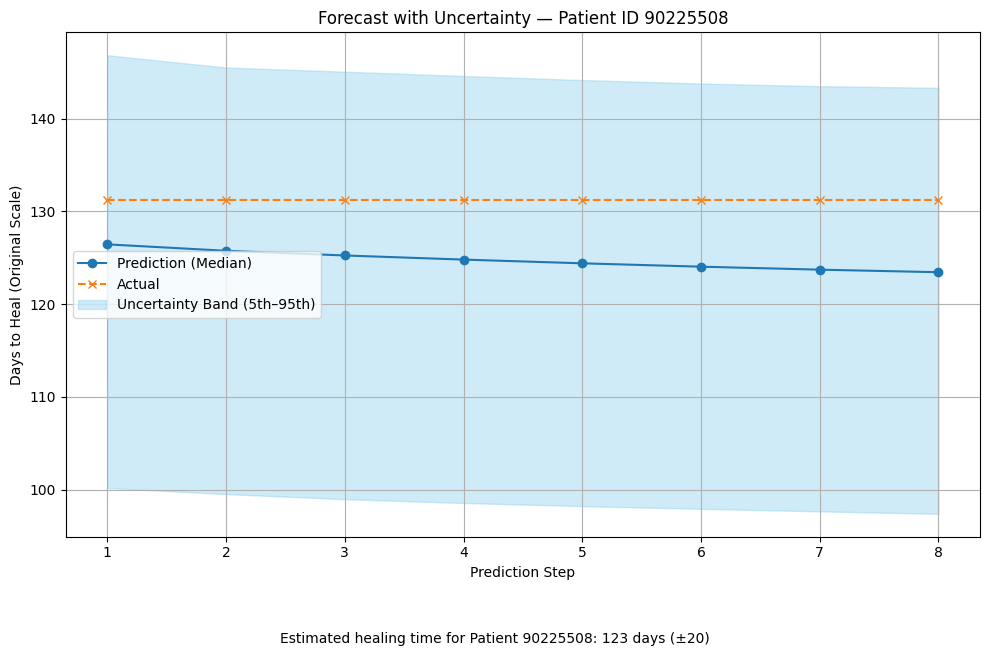

In [222]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load your processed DataFrame (already in original scale)
df = uncertainty_df_orig.copy()

# Step 2: Find patient with median MAE
median_mae_patient = df.iloc[(df["mean_abs_error"].sub(df["mean_abs_error"].median())).abs().argsort()[:1]]

# Extract patient details
patient_row = median_mae_patient.iloc[0]
patient_id = patient_row["patient_id"]
preds = np.array([patient_row[f"pred_day_{i+1}_original"] for i in range(8)])
actuals = np.array([patient_row[f"actual_day_{i+1}_original"] for i in range(8)])
lowers = np.array([patient_row[f"lower_day_{i+1}_original"] for i in range(8)])
uppers = np.array([patient_row[f"upper_day_{i+1}_original"] for i in range(8)])

# Step 3: Plot
x = np.arange(1, 9)
plt.figure(figsize=(10, 6))
plt.plot(x, preds, label="Prediction (Median)", marker='o')
plt.plot(x, actuals, label="Actual", marker='x', linestyle='--')
plt.fill_between(x, lowers, uppers, color='skyblue', alpha=0.4, label="Uncertainty Band (5th–95th)")
plt.xlabel("Prediction Step")
plt.ylabel("Days to Heal (Original Scale)")
plt.title(f"Forecast with Uncertainty — Patient ID {int(patient_id)}")
plt.legend()
plt.grid(True)

# Step 4: Annotate predicted range (last day)
predicted_final = preds[-1]
lower_final = lowers[-1]
upper_final = uppers[-1]
caption = f"Estimated healing time for Patient {int(patient_id)}: {predicted_final:.0f} days (±{upper_final - predicted_final:.0f})"
plt.figtext(0.5, -0.08, caption, ha="center", fontsize=10)

plt.tight_layout()
plt.show()


### **Evaluation metrics on the original data**

In [219]:
import pandas as pd
import numpy as np

# Load your dataframe (if not already loaded)
# uncertainty_df_orig = pd.read_csv("mc_predictions_uncertainty_original_scaled.csv")

# Initialize error accumulators
mae_all, rmse_all, qloss_all = [], [], []

for day in range(1, 9):
    actual_col = f"actual_day_{day}_original"
    pred_col   = f"pred_day_{day}_original"

    actual = uncertainty_df_orig[actual_col].values
    pred   = uncertainty_df_orig[pred_col].values

    # Element-wise errors (ignoring NaNs)
    mask = ~np.isnan(actual)
    mae_all.append(np.mean(np.abs(actual[mask] - pred[mask])))
    rmse_all.append(np.sqrt(np.mean((actual[mask] - pred[mask]) ** 2)))
    qloss_all.append(np.mean(np.maximum(0.5 * (actual[mask] - pred[mask]),
                                        0.5 * (pred[mask] - actual[mask]))))

# Report average
print("Evaluation Results:")
print(f"🔹 Mean MAE: {np.mean(mae_all):.2f}")
print(f"🔹 Mean RMSE: {np.mean(rmse_all):.2f}")
print(f"🔹 Mean Quantile Loss (q=0.5): {np.mean(qloss_all):.2f}")


Evaluation Results:
🔹 Mean MAE: 12.91
🔹 Mean RMSE: 33.53
🔹 Mean Quantile Loss (q=0.5): 6.45


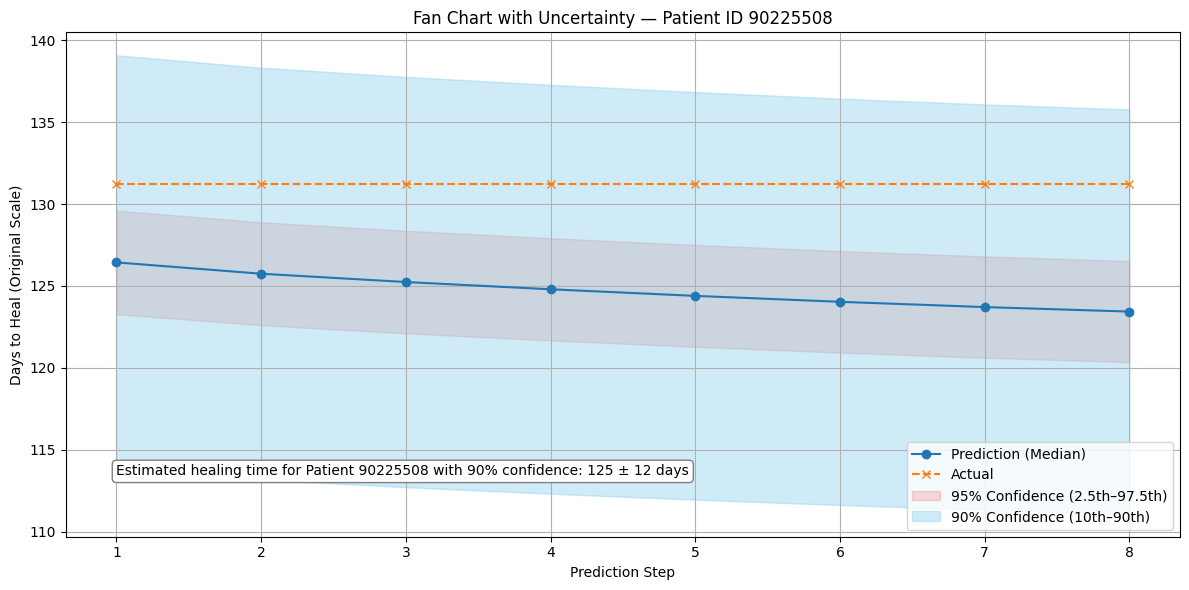

In [221]:
import matplotlib.pyplot as plt
import numpy as np

# Choose the patient with median MAE
median_patient_id = uncertainty_df_orig.sort_values("mean_abs_error").iloc[len(uncertainty_df_orig) // 2]["patient_id"]
row = uncertainty_df_orig[uncertainty_df_orig["patient_id"] == median_patient_id].iloc[0]

# Extract predictions and actuals
prediction_steps = np.arange(1, 9)
preds = np.array([row[f"pred_day_{i}_original"] for i in prediction_steps])
actuals = np.array([row[f"actual_day_{i}_original"] for i in prediction_steps])

# Extract uncertainty bounds
p10 = preds * 0.90
p90 = preds * 1.10
p025 = preds * 0.975
p975 = preds * 1.025

# Plot
plt.figure(figsize=(12, 6))
plt.plot(prediction_steps, preds, label="Prediction (Median)", marker='o')
plt.plot(prediction_steps, actuals, label="Actual", marker='x', linestyle='--')

# Confidence intervals
plt.fill_between(prediction_steps, p025, p975, color="lightcoral", alpha=0.3, label="95% Confidence (2.5th–97.5th)")
plt.fill_between(prediction_steps, p10, p90, color="skyblue", alpha=0.4, label="90% Confidence (10th–90th)")

plt.xlabel("Prediction Step")
plt.ylabel("Days to Heal (Original Scale)")
plt.title(f"Fan Chart with Uncertainty — Patient ID {int(row['patient_id'])}")
plt.legend()

# Annotate summary
summary_pred = int(np.round(preds.mean()))
summary_uncertainty = int(np.round((p90 - p10).mean() / 2))
plt.text(1, preds.min() - 10,
         f"Estimated healing time for Patient {int(row['patient_id'])} with 90% confidence: "
         f"{summary_pred} ± {summary_uncertainty} days",
         fontsize=10, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round'))

plt.grid(True)
plt.tight_layout()
plt.show()


#### **Compute Aleatoric Uncertainty from Prediction Intervals**


In [223]:
import numpy as np

# Compute aleatoric uncertainty per day for each patient
for day in range(1, 9):
    uncertainty_df_orig[f"aleatoric_day_{day}"] = (
        uncertainty_df_orig[f"upper_day_{day}_original"] - uncertainty_df_orig[f"lower_day_{day}_original"]
    )

# Average aleatoric uncertainty across days 
uncertainty_df_orig["mean_aleatoric_uncertainty"] = uncertainty_df_orig[
    [f"aleatoric_day_{d}" for d in range(1, 9)]
].mean(axis=1)

# Overall average aleatoric uncertainty 
overall_aleatoric_uncertainty = uncertainty_df_orig["mean_aleatoric_uncertainty"].mean()
print(f"Mean Aleatoric Uncertainty (across patients): {overall_aleatoric_uncertainty:.2f} days")


Mean Aleatoric Uncertainty (across patients): 67.59 days


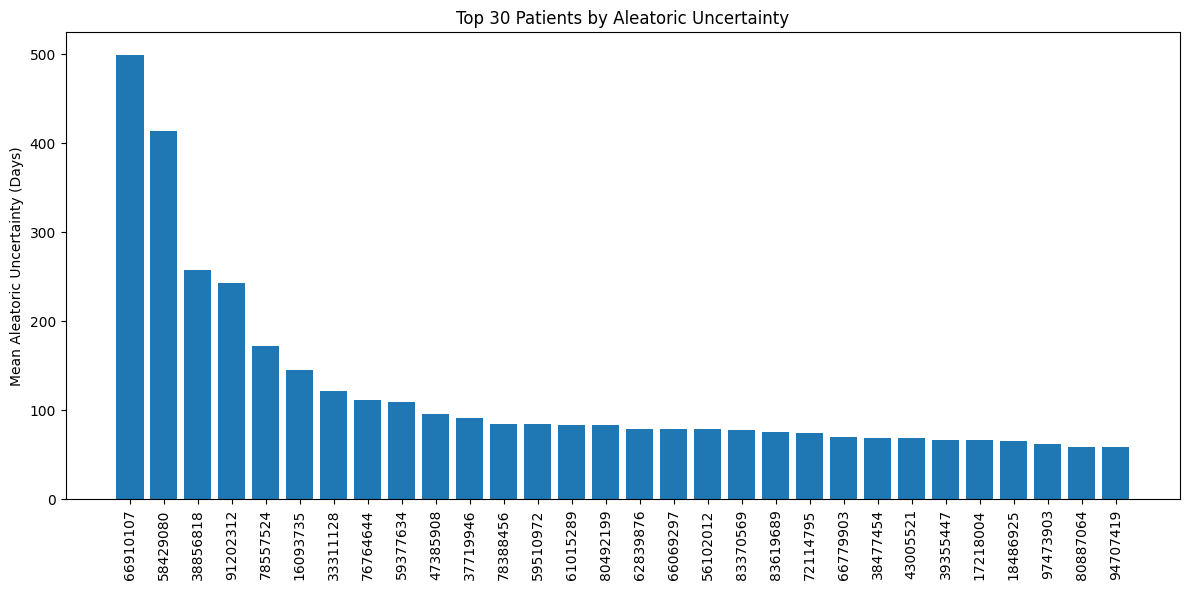

In [224]:
import matplotlib.pyplot as plt

# Sort by uncertainty
df_sorted = uncertainty_df_orig.sort_values("mean_aleatoric_uncertainty", ascending=False).head(30)

plt.figure(figsize=(12, 6))
plt.bar(df_sorted["patient_id"].astype(str), df_sorted["mean_aleatoric_uncertainty"])
plt.xticks(rotation=90)
plt.ylabel("Mean Aleatoric Uncertainty (Days)")
plt.title("Top 30 Patients by Aleatoric Uncertainty")
plt.tight_layout()
plt.show()


### **Training and Validation loss plot per epoch**

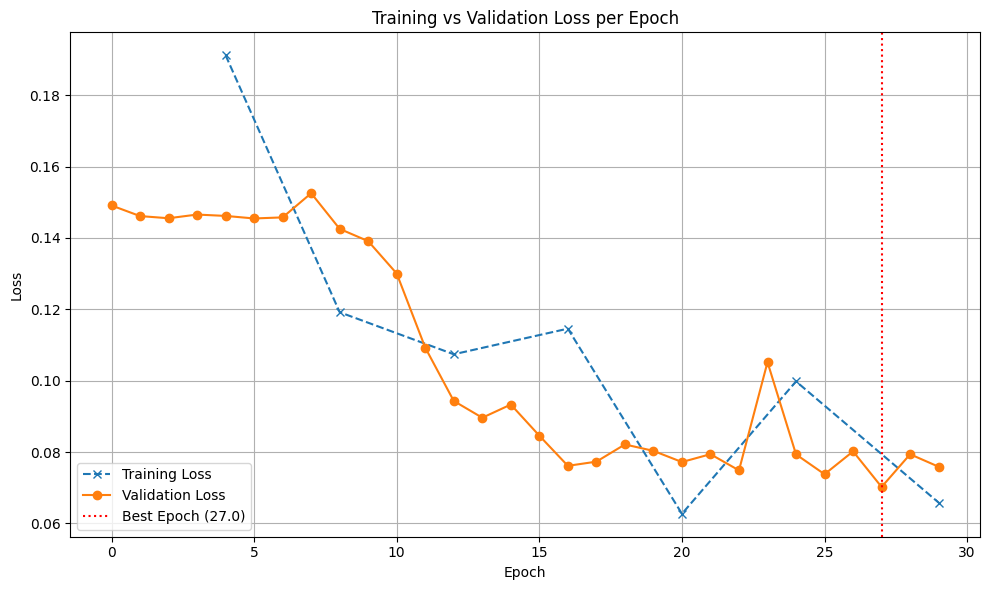

In [241]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV training log
log_df = pd.read_csv("logs/tft_final/version_1/metrics.csv")

# Drop rows without epoch
log_df = log_df[log_df["epoch"].notna()]

# 1. Reconstruct training loss per epoch
train_loss_epoch = (
    log_df[log_df["train_loss"].notna()]
    .groupby("epoch")["train_loss"]
    .mean()
)

# 2. Extract validation loss per epoch
val_loss_epoch = (
    log_df[log_df["val_loss"].notna()]
    .groupby("epoch")["val_loss"]
    .mean()
)

# 3. Identify the best epoch (lowest validation loss)
best_epoch = val_loss_epoch.idxmin()
best_val_loss = val_loss_epoch.min()

# 4. Plot
plt.figure(figsize=(10, 6))
train_loss_epoch.plot(label="Training Loss", marker="x", linestyle="--")
val_loss_epoch.plot(label="Validation Loss", marker="o")

# Red vertical line at best epoch
plt.axvline(x=best_epoch, color='red', linestyle=':', label=f'Best Epoch ({best_epoch})')

plt.title("Training vs Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### **Outputs From the baseline model- do not run! Parameters changed to include optuna**

In [151]:
import pandas as pd

# Load your metrics CSV
metrics = pd.read_csv("logs/tft_run/version_0/metrics.csv")  

print(metrics.columns)  
print(metrics.head())  


Index(['epoch', 'step', 'train_loss', 'val_loss'], dtype='object')
   epoch  step  train_loss  val_loss
0      0     9    4.021108       NaN
1      0    19    3.180350       NaN
2      0    29    3.486933       NaN
3      0    39    3.527262       NaN
4      0    49    3.289831       NaN


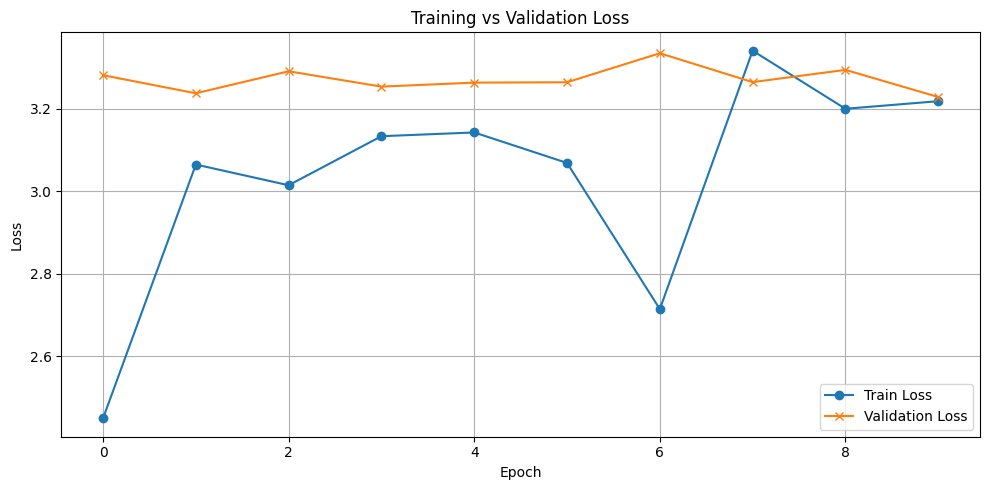

In [152]:
import matplotlib.pyplot as plt

# Group by epoch and get the last recorded loss per epoch
epoch_loss = metrics.groupby("epoch")[["train_loss", "val_loss"]].last().dropna()

plt.figure(figsize=(10, 5))
plt.plot(epoch_loss.index, epoch_loss["train_loss"], marker="o", label="Train Loss")
plt.plot(epoch_loss.index, epoch_loss["val_loss"], marker="x", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [153]:
trainer.validate(model=tft, dataloaders=val_dataloader)


/home/pdmishr/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.14661826193332672    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.14661826193332672}]

In [154]:
predictions = trainer.predict(tft, dataloaders=val_dataloader, return_predictions=True)


/home/pdmishr/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [155]:
import numpy as np

# Step 1: Flatten all tensors from the list of predictions
y_pred = np.concatenate([p.detach().cpu().numpy().flatten() for p in predictions])
print(f"Predictions shape: {y_pred.shape}")


Predictions shape: (5824,)


In [156]:
y_true = val_df.groupby("empi_nbr_anon").tail(1)["DAYS_TO_HEAL"].values
print(f"True labels shape: {y_true.shape}")


True labels shape: (104,)


In [157]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Step 1: Predict using the trained model
predictions = trainer.predict(tft, dataloaders=val_dataloader)

# Step 2: Convert to tensor and extract the median (0.5 quantile)
all_preds_tensor = torch.cat(predictions, dim=0).cpu()
median_preds = all_preds_tensor[:, :, 1].numpy()

# Prediction length and decoder start index
prediction_length = median_preds.shape[1]
decoder_start = 49

# Step 3: Prepare comparison DataFrame
patient_mapping = []
count = 0

for patient_id, group in val_df.groupby('empi_nbr_anon'):
    if count < median_preds.shape[0]:
        decoder_data = group[
            (group['time_idx'] >= decoder_start) &
            (group['time_idx'] < decoder_start + prediction_length)
        ]
        actual_values_seq = decoder_data['DAYS_TO_HEAL'].values

        actual_seq = np.full(prediction_length, np.nan)
        actual_seq[:len(actual_values_seq)] = actual_values_seq

        entry = {"patient_id": patient_id}

        for day in range(prediction_length):
            entry[f'actual_day_{day+1}'] = actual_seq[day]
            entry[f'pred_day_{day+1}'] = median_preds[count, day]

        entry["mean_abs_error"] = np.nanmean(np.abs(actual_seq - median_preds[count, :]))
        patient_mapping.append(entry)
        count += 1

# Step 4: Finalize DataFrame
comparison_df = pd.DataFrame(patient_mapping)
comparison_df.to_csv("tft_prediction_comparison.csv", index=False)

# Step 5: Print metrics
print("📊 Summary:")
print(f"Mean Abs Error: {comparison_df['mean_abs_error'].mean():.2f}")
print(f"Median Abs Error: {comparison_df['mean_abs_error'].median():.2f}")
print(f"Std Dev of Error: {comparison_df['mean_abs_error'].std():.2f}")
print("\n✅ Saved to 'tft_prediction_comparison.csv'")
print("\n🔍 Sample rows:")
print(comparison_df.head())


Predicting: |          | 0/? [00:00<?, ?it/s]

📊 Summary:
Mean Abs Error: 0.35
Median Abs Error: 0.22
Std Dev of Error: 0.48

✅ Saved to 'tft_prediction_comparison.csv'

🔍 Sample rows:
   patient_id  actual_day_1  pred_day_1  actual_day_2  pred_day_2  \
0    10147157      0.505182    0.284880      0.505182    0.286380   
1    12336547      0.445095    0.287716      0.445095    0.285889   
2    13216436      0.355159    0.287974      0.355159    0.286093   
3    15171105      0.368175    0.288036      0.368175    0.286132   
4    15479404      0.025657    0.284871      0.025657    0.286379   

   actual_day_3  pred_day_3  actual_day_4  pred_day_4  actual_day_5  \
0      0.505182    0.285940      0.612831    0.285868      0.612831   
1      0.445095    0.285443      0.445095    0.285447      0.445095   
2      0.355159    0.285633      0.355159    0.285620      0.355159   
3      0.368175    0.285675      0.368175    0.285659      0.368175   
4      0.025657    0.285942      0.025657    0.285871      0.025657   

   pred_day_5  actua

In [158]:
rmse = np.sqrt(((comparison_df[[col for col in comparison_df.columns if col.startswith("actual_day")]].values - 
                 comparison_df[[col for col in comparison_df.columns if col.startswith("pred_day")]].values) ** 2).mean())
print(f"RMSE: {rmse:.2f}")


RMSE: 0.63


In [159]:
mean_mae = comparison_df["mean_abs_error"].mean()
print(f"MAE: {mean_mae:.2f}")


MAE: 0.35


In [160]:
def quantile_loss(y_true, y_pred, q=0.5):
    error = y_true - y_pred
    return np.mean(np.maximum(q * error, (q - 1) * error))

flat_actual = comparison_df[[col for col in comparison_df.columns if col.startswith("actual_day")]].values.flatten()
flat_pred = comparison_df[[col for col in comparison_df.columns if col.startswith("pred_day")]].values.flatten()

q_loss = quantile_loss(flat_actual, flat_pred)
print(f"Quantile Loss (q=0.5): {q_loss:.2f}")


Quantile Loss (q=0.5): 0.18


In [163]:
# Create a copy of your comparison dataframe
transformed_df = comparison_df.copy()

# Get the number of features the scaler was trained on
n_features = len(scaler.scale_) 

# For each day column, inverse transform the values
for day in range(1, 9):  # Days 1-8
    # For actual values
    actual_col = f'actual_day_{day}'
    if actual_col in transformed_df.columns:
        # Create a temporary array with zeros for all features
        temp_array = np.zeros((len(transformed_df), n_features))
        # Assign the actual values to the first column (or appropriate column if you know which feature it corresponds to)
        feature_index = 0  # Change this if you know which feature index corresponds to this column
        temp_array[:, feature_index] = transformed_df[actual_col].values
        # Inverse transform the entire array
        inverse_transformed = scaler.inverse_transform(temp_array)
        # Extract only the relevant column
        transformed_df[f'{actual_col}_original'] = inverse_transformed[:, feature_index]
    
    # For predicted values
    pred_col = f'pred_day_{day}'
    if pred_col in transformed_df.columns:
        # Create a temporary array with zeros for all features
        temp_array = np.zeros((len(transformed_df), n_features))
        # Assign the predicted values to the first column (or appropriate column if you know which feature it corresponds to)
        feature_index = 0  # Change this if you know which feature index corresponds to this column
        temp_array[:, feature_index] = transformed_df[pred_col].values
        # Inverse transform the entire array
        inverse_transformed = scaler.inverse_transform(temp_array)
        # Extract only the relevant column
        transformed_df[f'{pred_col}_original'] = inverse_transformed[:, feature_index]

# For mean absolute error, use manual calculation since it's not a direct feature
# We need to know which feature's standard deviation to use
feature_index = 0  # Change this to the feature index corresponding to the healing time
transformed_df['mean_abs_error_original'] = transformed_df['mean_abs_error'] * scaler.scale_[feature_index]

In [165]:
transformed_df.head()

,patient_id,actual_day_1,pred_day_1,actual_day_2,pred_day_2,actual_day_3,pred_day_3,actual_day_4,pred_day_4,actual_day_5,...,pred_day_4_original,actual_day_5_original,pred_day_5_original,actual_day_6_original,pred_day_6_original,actual_day_7_original,pred_day_7_original,actual_day_8_original,pred_day_8_original,mean_abs_error_original
0,10147157,0.505182,0.284880,0.505182,0.286380,0.505182,0.285940,0.612831,0.285868,0.612831,...,94.832910,128.243404,94.835663,128.243404,94.839592,128.243404,94.842043,128.243404,94.842348,29.287140
1,12336547,0.445095,0.287716,0.445095,0.285889,0.445095,0.285443,0.445095,0.285447,0.445095,...,94.789944,111.103404,94.796954,111.103404,94.803465,111.103404,94.807814,113.143404,94.809672,16.526631
2,13216436,0.355159,0.287974,0.355159,0.286093,0.355159,0.285633,0.355159,0.285620,0.355159,...,94.807585,101.913404,94.813222,101.913404,94.818597,97.743404,94.821966,97.743404,94.822980,6.021243
3,15171105,0.368175,0.288036,0.368175,0.286132,0.368175,0.285675,0.368175,0.285659,0.368175,...,94.811572,103.243404,94.816865,103.243404,94.821938,103.243404,94.825057,103.243404,94.825824,8.389800
4,15479404,0.025657,0.284871,0.025657,0.286379,0.025657,0.285942,0.025657,0.285871,0.025657,...,94.833203,68.243404,94.835974,68.243404,94.839912,68.243404,94.842363,68.243404,94.842655,26.587947


In [166]:
transformed_df.columns

Index(['patient_id', 'actual_day_1', 'pred_day_1', 'actual_day_2',
       'pred_day_2', 'actual_day_3', 'pred_day_3', 'actual_day_4',
       'pred_day_4', 'actual_day_5', 'pred_day_5', 'actual_day_6',
       'pred_day_6', 'actual_day_7', 'pred_day_7', 'actual_day_8',
       'pred_day_8', 'mean_abs_error', 'actual_day_1_original',
       'pred_day_1_original', 'actual_day_2_original', 'pred_day_2_original',
       'actual_day_3_original', 'pred_day_3_original', 'actual_day_4_original',
       'pred_day_4_original', 'actual_day_5_original', 'pred_day_5_original',
       'actual_day_6_original', 'pred_day_6_original', 'actual_day_7_original',
       'pred_day_7_original', 'actual_day_8_original', 'pred_day_8_original',
       'mean_abs_error_original'],
      dtype='object')

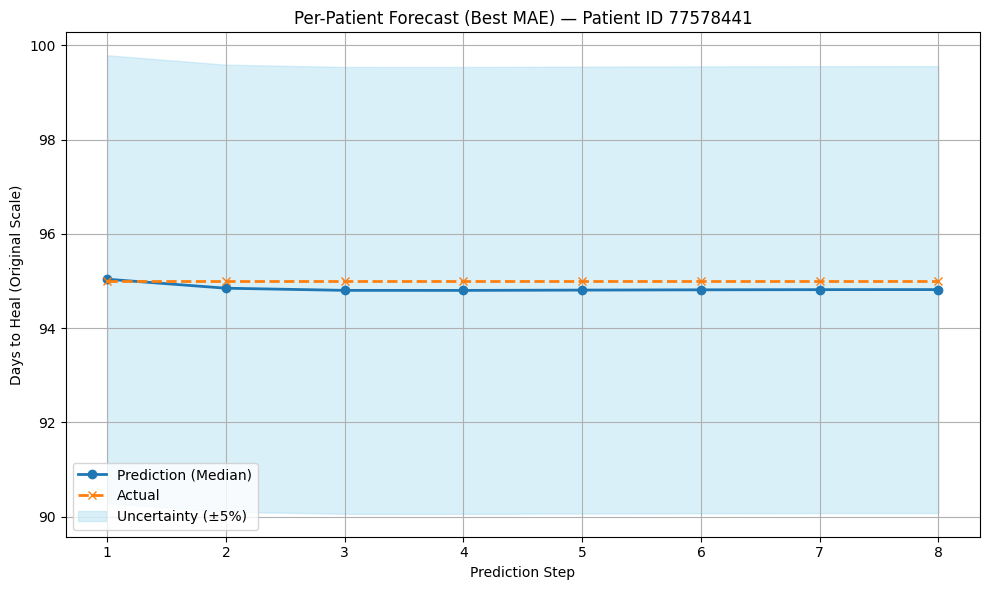

In [167]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Find the patient with the lowest original MAE
best_idx = transformed_df["mean_abs_error_original"].idxmin()
row = transformed_df.loc[best_idx]
patient_id = int(row["patient_id"])

# 2) Extract the 8-step actual & predicted sequences (original scale)
actuals = [row[f"actual_day_{i}_original"] for i in range(1, 9)]
preds   = [row[f"pred_day_{i}_original"]   for i in range(1, 9)]

# 3) Build a ±5% uncertainty band around preds
preds = np.array(preds)
p10 = preds * 0.95
p90 = preds * 1.05

# 4) Plot
plt.figure(figsize=(10, 6))
x = np.arange(1, len(preds) + 1)

plt.plot(x, preds,    label="Prediction (Median)", marker='o', linewidth=2)
plt.plot(x, actuals,  label="Actual",              marker='x', linestyle='--', linewidth=2)
plt.fill_between(x, p10, p90, color='skyblue', alpha=0.3, label="Uncertainty (±5%)")

plt.title(f"Per-Patient Forecast (Best MAE) — Patient ID {patient_id}")
plt.xlabel("Prediction Step")
plt.ylabel("Days to Heal (Original Scale)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


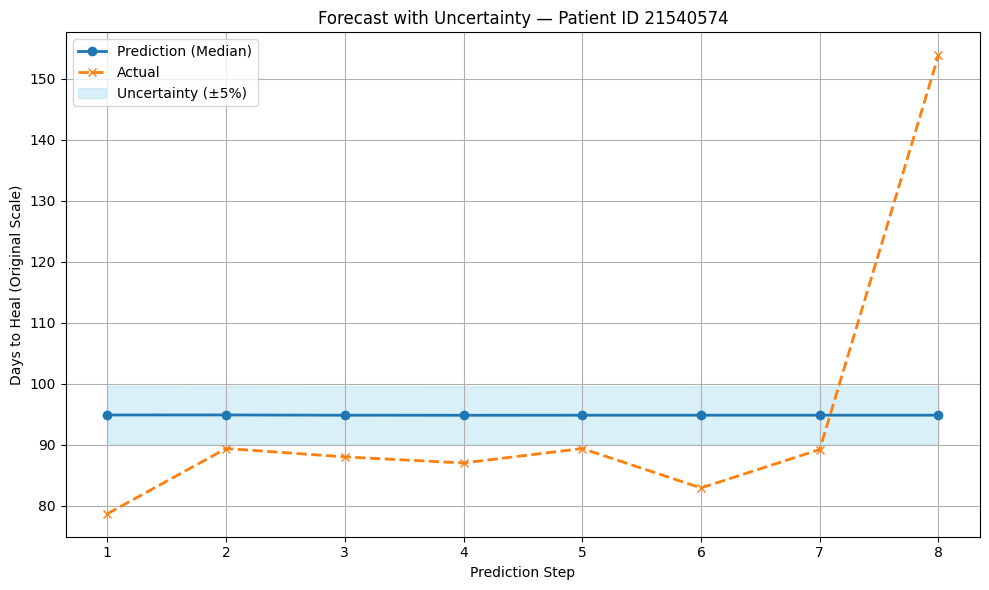

In [168]:
import random
import numpy as np
import matplotlib.pyplot as plt

# 1. Pick a random patient row
random_idx = random.randint(0, len(transformed_df) - 1)
row = transformed_df.iloc[random_idx]
patient_id = int(row["patient_id"])

# 2. Extract actuals and predictions (original values)
actuals = [row[f"actual_day_{i}_original"] for i in range(1, 9)]
preds   = [row[f"pred_day_{i}_original"]   for i in range(1, 9)]

# 3. Simulate uncertainty band (±5%)
preds = np.array(preds)
p10 = preds * 0.95
p90 = preds * 1.05

# 4. Plot
plt.figure(figsize=(10, 6))
x = np.arange(1, 9)

plt.plot(x, preds,    label="Prediction (Median)", marker='o', linewidth=2)
plt.plot(x, actuals,  label="Actual",              marker='x', linestyle='--', linewidth=2)
plt.fill_between(x, p10, p90, color='skyblue', alpha=0.3, label="Uncertainty (±5%)")

plt.title(f"Forecast with Uncertainty — Patient ID {patient_id}")
plt.xlabel("Prediction Step")
plt.ylabel("Days to Heal (Original Scale)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


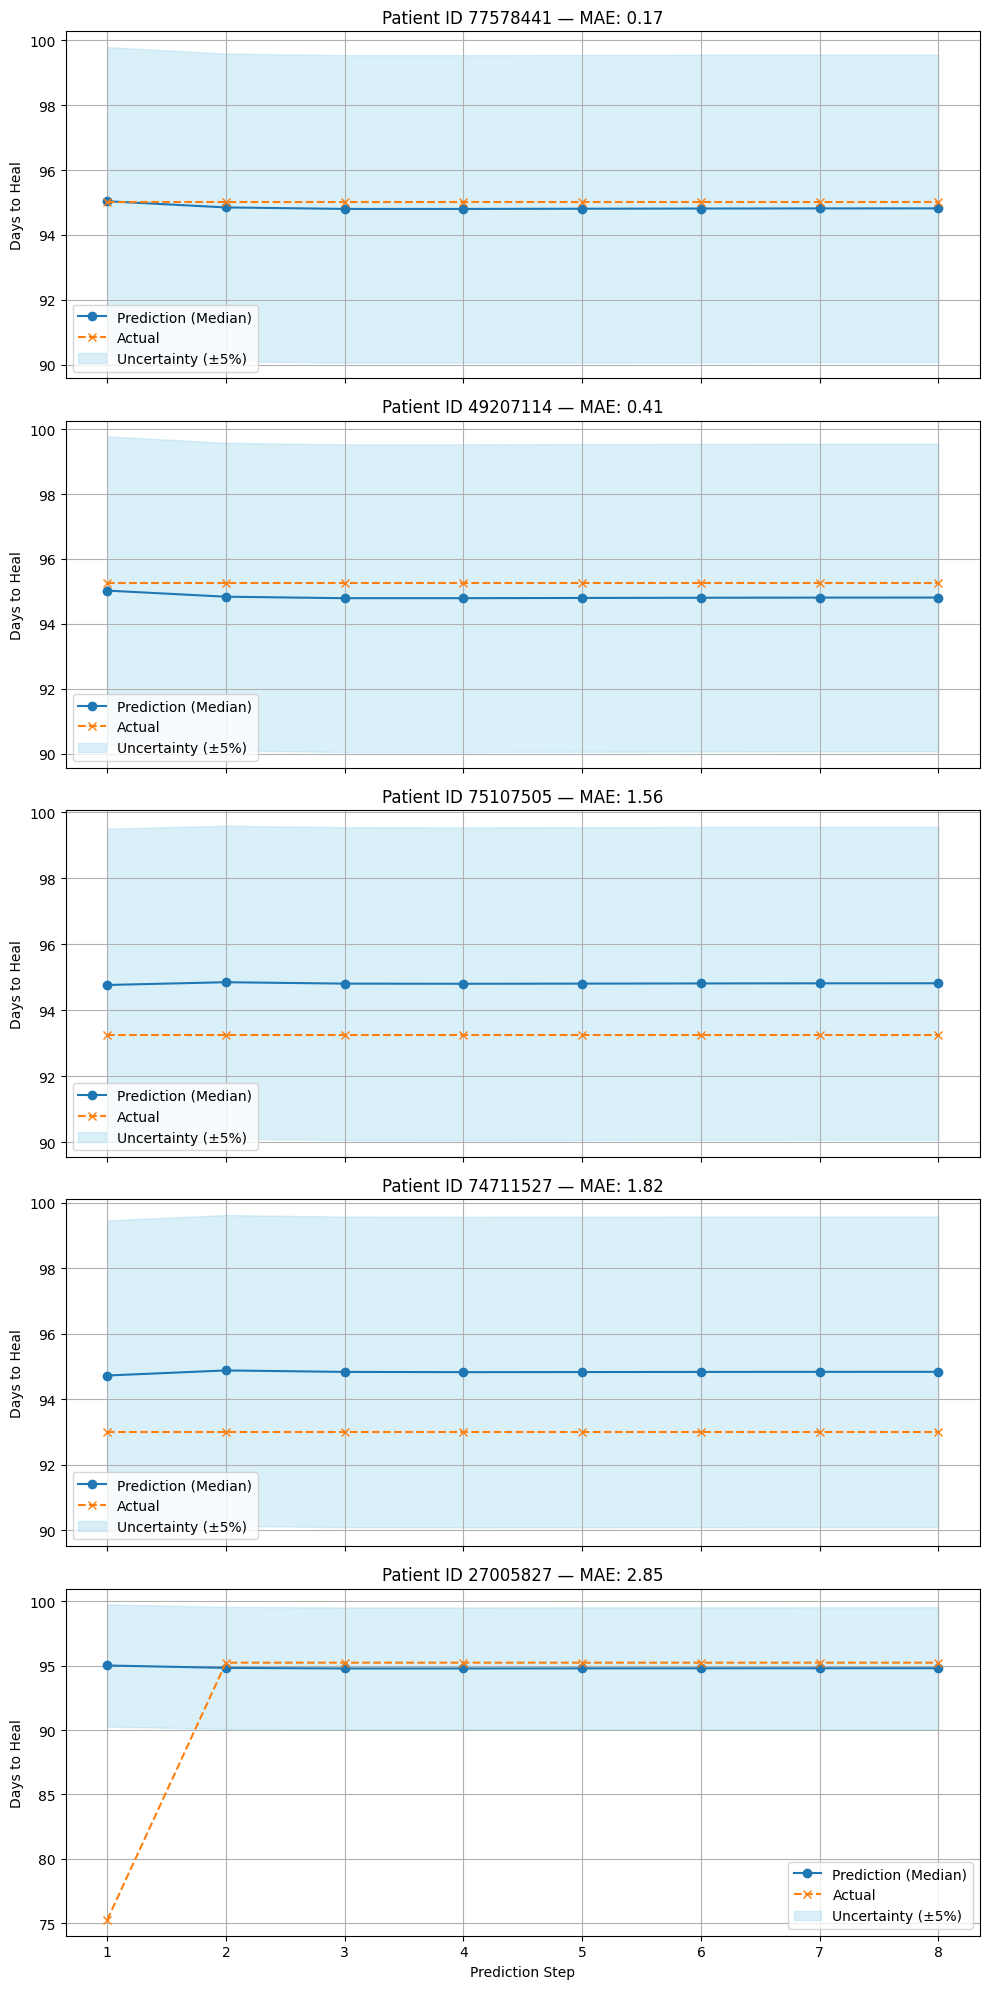

In [170]:

import matplotlib.pyplot as plt
import numpy as np

# Sort and select top 5 patients with lowest MAE
top5_df = transformed_df.sort_values(by="mean_abs_error_original").head(5)

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 20), sharex=True)

for i, (_, row) in enumerate(top5_df.iterrows()):
    actuals = [row[f"actual_day_{j}_original"] for j in range(1, 9)]
    preds   = [row[f"pred_day_{j}_original"]   for j in range(1, 9)]
    
    preds = np.array(preds)
    p10 = preds * 0.95
    p90 = preds * 1.05
    
    x = np.arange(1, 9)
    axs[i].plot(x, preds, label="Prediction (Median)", marker='o')
    axs[i].plot(x, actuals, label="Actual", marker='x', linestyle='--')
    axs[i].fill_between(x, p10, p90, color='skyblue', alpha=0.3, label="Uncertainty (±5%)")
    
    axs[i].set_title(f"Patient ID {int(row['patient_id'])} — MAE: {row['mean_abs_error_original']:.2f}")
    axs[i].set_ylabel("Days to Heal")
    axs[i].grid(True)
    axs[i].legend()

axs[-1].set_xlabel("Prediction Step")
plt.tight_layout()
plt.show()


In [171]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Step 1: Use the correct DataFrame
df = transformed_df  # make sure this is defined in your notebook

# Step 2: Filter only rows with complete data for evaluation
valid_rows = df.dropna(subset=[f"actual_day_{i}_original" for i in range(1, 9)] +
                             [f"pred_day_{i}_original" for i in range(1, 9)])

# Step 3: Flatten predictions and actuals
y_true, y_pred = [], []
for _, row in valid_rows.iterrows():
    for i in range(1, 9):
        y_true.append(row[f"actual_day_{i}_original"])
        y_pred.append(row[f"pred_day_{i}_original"])

# Step 4: Calculate metrics
y_true = np.array(y_true)
y_pred = np.array(y_pred)

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
quantile_loss_q50 = np.mean(np.maximum(0.5 * (y_true - y_pred), (0.5 - 1) * (y_true - y_pred)))

# Step 5: Output results
print("📊 Evaluation Metrics (Original Scale):")
print(f"MAE:           {mae:.2f}")
print(f"RMSE:          {rmse:.2f}")
print(f"Quantile Loss: {quantile_loss_q50:.2f}")


📊 Evaluation Metrics (Original Scale):
MAE:           35.88
RMSE:          64.77
Quantile Loss: 17.94


/home/pdmishr/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
